In [ ]:
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt
import os, random, pickle
import io
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)


### Part A: FR using Deepface under Simple Gaussian Noise

In [ ]:
# Load LFW and Grouped by for FR task
print("Loading the LFW dataset...")
lfw = load_dataset("bitmind/lfw")
lfw_dataset = lfw["train"]
print("LFW dataset loaded successfully.")

person_images = {}
for i in range(len(lfw_dataset)):
    filename = lfw_dataset[i]["filename"]
    image = lfw_dataset[i]["image"]
    name = '_'.join(filename.split('_')[:-1])
    person_images.setdefault(name, []).append((image, filename))

persons = {k: v for k, v in person_images.items() if len(v) > 1}
print(f"Number of persons with >1 image: {len(persons)}")

In [ ]:
MODEL = "Facenet"  
def get_embedding(img):
    rep = DeepFace.represent(
        img_path=np.array(img.convert("RGB"))[:, :, ::-1],
        model_name=MODEL,
        detector_backend="mtcnn",
        enforce_detection=False,  
        align=True
    )
    return rep[0]["embedding"]


EMB_FILE = "lfw_embeddings.pkl"

if os.path.exists(EMB_FILE):
    print("Loading precomputed embeddings...")
    with open(EMB_FILE, "rb") as f:
        db_embeddings, test_set = pickle.load(f)
else:
    print("Computing embeddings (first run, this will take a while)...")
    db_embeddings = {}
    test_set = []

    random.seed(42)
    for name, images in persons.items():
        random.shuffle(images)
        split = max(1, len(images) // 2)
        train = images[:split]
        test = images[split:]
        if len(train) == 0 or len(test) == 0:
            continue
        db_embeddings[name] = [get_embedding(img) for img, _ in train]
        for img, fname in test:
            test_set.append({"image": img, "filename": fname, "true_label": name})

    with open(EMB_FILE, "wb") as f:
        pickle.dump((db_embeddings, test_set), f)
    print("Saved embeddings to", EMB_FILE)

print(f"Database size: {sum(len(v) for v in db_embeddings.values())}")
print(f"Test set size: {len(test_set)}")


In [ ]:
def add_gaussian_noise(image, mean=0, std=25):
    img_array = np.array(image).astype(np.float32)
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def denoise_image(image):
    img_array = np.array(image)
    denoised = cv2.fastNlMeansDenoisingColored(img_array, None, 10, 10, 7, 21)
    return Image.fromarray(denoised)

for sample in test_set:
    sample["noisy_image"] = add_gaussian_noise(sample["image"])

In [ ]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def evaluate(test_images_key):
    true_labels, pred_labels = [], []
    top5_correct = 0
    sim_scores, sim_labels = [], []

    for sample in test_set:
        true_label = sample["true_label"]
        img = sample[test_images_key]
        emb = get_embedding(img)

        # Top-1, Top-5
        scores = {p: max([cosine_sim(emb, r) for r in reps]) for p, reps in db_embeddings.items()}
        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        pred = ranked[0][0]
        pred_labels.append(pred)
        true_labels.append(true_label)
        if true_label in [p for p, _ in ranked[:5]]:
            top5_correct += 1

        # ROC / Verification
        for person, reps in db_embeddings.items():
            for r in reps:
                sim = cosine_sim(emb, r)
                sim_scores.append(sim)
                sim_labels.append(1 if person == true_label else 0)

    # Metrics
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
    rec = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)
    top5_acc = top5_correct / len(test_set)
    fpr, tpr, _ = roc_curve(sim_labels, sim_scores)
    auc = roc_auc_score(sim_labels, sim_scores)

    return {
        "acc": acc, "top5_acc": top5_acc, "prec": prec,
        "rec": rec, "f1": f1, "fpr": fpr, "tpr": tpr, "auc": auc,
        "true_labels": true_labels, "pred_labels": pred_labels
    }

Loading the LFW dataset...
LFW dataset loaded successfully.
Number of persons with >1 image: 1680
Loading precomputed embeddings...
Database size: 4307
Test set size: 4857
Evaluating Clean Images...
Evaluating Noisy Images...
Evaluating Denoised Images...

=== Clean Results ===
Top-1 Accuracy: 0.8124356598723492
Top-5 Accuracy: 0.881408276714021
Precision: 0.7821931422673277
Recall: 0.8124356598723492
F1 Score: 0.7852336233332703
ROC AUC: 0.9605458534596298

=== Noisy Results ===
Top-1 Accuracy: 0.6044883673049207
Top-5 Accuracy: 0.7405806053119209
Precision: 0.6361116223841492
Recall: 0.6044883673049207
F1 Score: 0.5959941084493279
ROC AUC: 0.9505613443098736

=== Denoised Results ===
Top-1 Accuracy: 0.6746963145974881
Top-5 Accuracy: 0.7951410335598106
Precision: 0.6665573763995485
Recall: 0.6746963145974881
F1 Score: 0.6514222695734203
ROC AUC: 0.9529849156400514


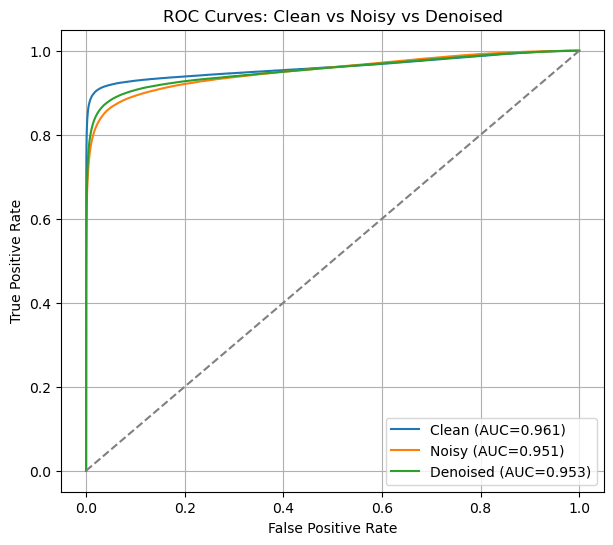

Saved recognition_results_robustness.csv


In [ ]:
print("Evaluating Clean Images...")
for sample in test_set:
    sample["clean_image"] = sample["image"]
clean_metrics = evaluate("clean_image")

print("Evaluating Noisy Images...")
for sample in test_set:
    sample["noisy_image"] = add_gaussian_noise(sample["image"])
noisy_metrics = evaluate("noisy_image")

print("Evaluating Denoised Images...")
for sample in test_set:
    sample["denoised_image"] = denoise_image(sample["noisy_image"])
denoised_metrics = evaluate("denoised_image")

def print_metrics(name, metrics):
    print(f"\n=== {name} Results ===")
    print("Top-1 Accuracy:", metrics["acc"])
    print("Top-5 Accuracy:", metrics["top5_acc"])
    print("Precision:", metrics["prec"])
    print("Recall:", metrics["rec"])
    print("F1 Score:", metrics["f1"])
    print("ROC AUC:", metrics["auc"])

print_metrics("Clean", clean_metrics)
print_metrics("Noisy", noisy_metrics)
print_metrics("Denoised", denoised_metrics)

plt.figure(figsize=(7, 6))
plt.plot(clean_metrics["fpr"], clean_metrics["tpr"], label=f"Clean (AUC={clean_metrics['auc']:.3f})")
plt.plot(noisy_metrics["fpr"], noisy_metrics["tpr"], label=f"Noisy (AUC={noisy_metrics['auc']:.3f})")
plt.plot(denoised_metrics["fpr"], denoised_metrics["tpr"], label=f"Denoised (AUC={denoised_metrics['auc']:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Clean vs Noisy vs Denoised")
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame({
    "True Label": clean_metrics["true_labels"],
    "Predicted Clean": clean_metrics["pred_labels"],
    "Predicted Noisy": noisy_metrics["pred_labels"],
    "Predicted Denoised": denoised_metrics["pred_labels"]
})
results_df.to_csv("recognition_results_robustness.csv", index=False)
print("Saved recognition_results_robustness.csv")


### Part B: FR Under Gradient-base Attacks

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 160
RANDOM_SEED = 42
MAX_SAMPLES = 300
CACHE_FILE = "lfw_facenet_cache_probe300.pkl"

IMG_EPS = 8/255.0
NORM_EPS = 2 * IMG_EPS
PGD_ALPHA_IMG = 2/255.0
NORM_ALPHA = 2 * PGD_ALPHA_IMG
PGD_ITERS = 15

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
print("Loading FaceNet model (InceptionResnetV1 pretrained=vggface2)...")
model = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  
])

def pil_to_tensor(img_pil):
    if not isinstance(img_pil, Image.Image):
        img_pil = Image.fromarray(np.array(img_pil))
    img_pil = img_pil.convert("RGB")
    return preprocess(img_pil).unsqueeze(0).to(DEVICE)  

def tensor_to_pil(tensor):
    t = tensor.detach().cpu().squeeze(0)  
    t = t * 0.5 + 0.5
    t = torch.clamp(t, 0.0, 1.0)
    npimg = (t.permute(1,2,0).numpy() * 255.0).astype(np.uint8)
    return Image.fromarray(npimg)

@torch.no_grad()
def embedding_from_pil(img_pil):
    t = pil_to_tensor(img_pil)
    emb = model(t)  
    return emb.squeeze(0).cpu().numpy() 


Loading FaceNet model (InceptionResnetV1 pretrained=vggface2)...


In [19]:
def cosine_sim(a, b):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)
    return float(np.dot(a, b) / denom)

In [20]:
def fgsm_attack(img_pil, eps_norm=NORM_EPS):
    model.eval()
    x = pil_to_tensor(img_pil).clone().detach()
    x.requires_grad = True
    orig_emb = model(x).detach().squeeze(0)
    loss = -F.cosine_similarity(model(x), orig_emb.unsqueeze(0)).mean()
    loss.backward()
    x_adv = x + eps_norm * x.grad.data.sign()
    x_adv = torch.clamp(x_adv, -1.0, 1.0).detach()
    return tensor_to_pil(x_adv)

def pgd_attack(img_pil, eps_norm=NORM_EPS, alpha_norm=NORM_ALPHA, iters=PGD_ITERS):
    model.eval()
    x_orig = pil_to_tensor(img_pil).detach()
    x = x_orig + torch.empty_like(x_orig).uniform_(-eps_norm, eps_norm)
    x = torch.clamp(x, -1.0, 1.0).detach()
    orig_emb = model(x_orig).detach().squeeze(0)
    for _ in range(iters):
        x.requires_grad = True
        loss = -F.cosine_similarity(model(x), orig_emb.unsqueeze(0)).mean()
        loss.backward()
        with torch.no_grad():
            x = x + alpha_norm * x.grad.sign()
            x = torch.max(torch.min(x, x_orig + eps_norm), x_orig - eps_norm)
            x = torch.clamp(x, -1.0, 1.0).detach()
    return tensor_to_pil(x)

In [21]:
def denoise(img_pil):
    arr = np.array(img_pil.convert("RGB"))
    den = cv2.fastNlMeansDenoisingColored(arr, None, 10, 10, 7, 21)
    return Image.fromarray(den)


In [ ]:
def augment_db_with_adv_images(db_train_images, attack_fn, description="adv_aug"):
    print(f"Augmenting DB with adversarial images ({description})...")
    db_aug = {}
    for person, imgs in tqdm(db_train_images.items()):
        emb_list = []
        for img in imgs:
            emb = embedding_from_pil(img)
            emb_list.append(emb)
        for img in imgs:
            adv = attack_fn(img)
            emb_adv = embedding_from_pil(adv)
            emb_list.append(emb_adv)
        db_aug[person] = emb_list
    return db_aug

In [ ]:
def build_db_and_test(lfw_dataset, max_samples=MAX_SAMPLES):
    person_images = {}
    for i in range(len(lfw_dataset)):
        fname = lfw_dataset[i]["filename"]
        img = lfw_dataset[i]["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        img = img.convert("RGB")
        name = "_".join(fname.split("_")[:-1])
        person_images.setdefault(name, []).append((img, fname))

    persons = {k:v for k,v in person_images.items() if len(v) > 1}
    print("Persons with >1 image:", len(persons))

    db_train_images = {}
    test_set = []

    for name, imgs in tqdm(list(persons.items())):
        random.shuffle(imgs)
        split = max(1, len(imgs)//2)
        train_entries = imgs[:split]
        test_entries = imgs[split:]
        if not train_entries or not test_entries:
            continue
        db_train_images[name] = [img for (img, fname) in train_entries]
        for img, fname in test_entries:
            test_set.append({"image": img, "filename": fname, "true_label": name})

    random.Random(RANDOM_SEED).shuffle(test_set)
    if len(test_set) > max_samples:
        test_set = test_set[:max_samples]

    print("Computing DB embeddings (original training images)...")
    db_embeddings = {}
    for person, imgs in tqdm(db_train_images.items()):
        reps = [embedding_from_pil(img) for img in imgs]
        db_embeddings[person] = reps

    return db_train_images, db_embeddings, test_set


In [ ]:

def evaluate_probes(probe_images, db_embs, defense_fn=None):
    emb_list = []
    preds_top1 = []
    preds_top5 = []
    for img in probe_images:
        img_eval = defense_fn(img) if defense_fn is not None else img
        emb = embedding_from_pil(img_eval)
        emb_list.append(emb)

        scores = []
        for person, reps in db_embs.items():
            sims = [cosine_sim(emb, r) for r in reps]
            best = max(sims) if sims else -1.0
            scores.append((person, best))
        ranked = sorted(scores, key=lambda x: x[1], reverse=True)
        preds_top1.append(ranked[0][0] if ranked else None)
        preds_top5.append([p for p, _ in ranked[:5]])
    return emb_list, preds_top1, preds_top5

def compute_verification_roc(embs, true_labels, db_embs):
    sims = []
    labs = []
    for emb, true in zip(embs, true_labels):
        for person, reps in db_embs.items():
            for rep in reps:
                sims.append(cosine_sim(emb, rep))
                labs.append(1 if person == true else 0)
    if len(sims) == 0 or len(set(labs)) < 2:
        return [], [], 0.5
    fpr, tpr, _ = roc_curve(labs, sims)
    auc = roc_auc_score(labs, sims)
    return fpr.tolist(), tpr.tolist(), float(auc)

def compute_metrics(embs, preds_top1, preds_top5, true_labels, db_embs, name):
    acc1 = accuracy_score(true_labels, preds_top1)
    acc5 = sum(1 for t, top5 in zip(true_labels, preds_top5) if t in top5) / max(1, len(true_labels))
    prec = precision_score(true_labels, preds_top1, average="micro", zero_division=0)
    rec = recall_score(true_labels, preds_top1, average="micro", zero_division=0)
    f1 = f1_score(true_labels, preds_top1, average="micro", zero_division=0)
    fpr, tpr, auc = compute_verification_roc(embs, true_labels, db_embs)
    print(f"{name}: Top1={acc1:.4f}, Top5={acc5:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")
    return {"name": name, "acc1": acc1, "acc5": acc5, "prec": prec, "rec": rec, "f1": f1, "auc": auc, "fpr": fpr, "tpr": tpr}


In [ ]:
if __name__ == "__main__":
    print("Loading LFW dataset...")
    lfw = load_dataset("bitmind/lfw")["train"]

    db_train_images, db_embeddings_clean, test_set = build_db_and_test(lfw, max_samples=MAX_SAMPLES)
    print("DB persons:", len(db_embeddings_clean), "Test set size:", len(test_set))

    probe_imgs = [s["image"] for s in test_set]
    true_labels = [s["true_label"] for s in test_set]
    filenames = [s["filename"] for s in test_set]
    n = len(probe_imgs)
    print(f"Using {n} probe images (MAX_SAMPLES={MAX_SAMPLES})")

    print("Generating adversarial probes for the chosen probe images...")
    fgsm_probes = [fgsm_attack(img) for img in tqdm(probe_imgs)]
    pgd_probes  = [pgd_attack(img) for img in tqdm(probe_imgs)]

    db_embeddings_fgsm_aug = augment_db_with_adv_images(db_train_images, fgsm_attack, description="FGSM")
    db_embeddings_pgd_aug  = augment_db_with_adv_images(db_train_images, pgd_attack, description="PGD")

    scenario_names = [
        "CLEAN",
        "CLEAN+DENOISE",
        "CLEAN+ADV",
        "CLEAN+ADV+DENOISE",  
        "FGSM",
        "FGSM+DENOISE",
        "FGSM+ADV",
        "FGSM+ADV+DENOISE",
        "PGD",
        "PGD+DENOISE",
        "PGD+ADV",
        "PGD+ADV+DENOISE"
    ]
    per_sample_rows = [{"filename": filenames[i], "true_label": true_labels[i]} for i in range(n)]
    summary_results = []
    roc_curves = {}

    # Helper runner that stores per-sample predictions & summary
    def run_and_store(scn_name, probe_images_s, db_embs_for_eval, defense_fn=None):
        embs, p1, p5 = evaluate_probes(probe_images_s, db_embs_for_eval, defense_fn=defense_fn)
        metrics = compute_metrics(embs, p1, p5, true_labels, db_embs_for_eval, scn_name)
        summary_results.append({k: metrics[k] for k in ["name","acc1","acc5","prec","rec","f1","auc"]})
        roc_curves[scn_name] = {"fpr": metrics["fpr"], "tpr": metrics["tpr"], "auc": metrics["auc"]}
        for i in range(n):
            per_sample_rows[i][f"pred_{scn_name}"] = p1[i]
            per_sample_rows[i][f"pred_{scn_name}_top5"] = "|".join(p5[i]) if p5[i] else ""
        return metrics

    # CLEAN baseline (no denoise, clean DB)
    run_and_store("CLEAN", probe_imgs, db_embeddings_clean, defense_fn=None)

    # CLEAN + denoise
    run_and_store("CLEAN+DENOISE", probe_imgs, db_embeddings_clean, defense_fn=denoise)

    # CLEAN + ADV-DB (we'll use FGSM-augmented DB and PGD-augmented DB separately below;
    # here keep original DB augmented by both types for symmetry if desired)
    run_and_store("CLEAN+ADV", probe_imgs, db_embeddings_fgsm_aug, defense_fn=None)  
    run_and_store("CLEAN+ADV+DENOISE", probe_imgs, db_embeddings_fgsm_aug, defense_fn=denoise)

    # FGSM: probes = fgsm_probes, DB variants clean and fgsm-aug
    run_and_store("FGSM", fgsm_probes, db_embeddings_clean, defense_fn=None)
    run_and_store("FGSM+DENOISE", fgsm_probes, db_embeddings_clean, defense_fn=denoise)
    run_and_store("FGSM+ADV", fgsm_probes, db_embeddings_fgsm_aug, defense_fn=None)
    run_and_store("FGSM+ADV+DENOISE", fgsm_probes, db_embeddings_fgsm_aug, defense_fn=denoise)

    # PGD: probes = pgd_probes, DB variants clean and pgd-aug
    run_and_store("PGD", pgd_probes, db_embeddings_clean, defense_fn=None)
    run_and_store("PGD+DENOISE", pgd_probes, db_embeddings_clean, defense_fn=denoise)
    run_and_store("PGD+ADV", pgd_probes, db_embeddings_pgd_aug, defense_fn=None)
    run_and_store("PGD+ADV+DENOISE", pgd_probes, db_embeddings_pgd_aug, defense_fn=denoise)

    # ---- Save outputs ----
    df_samples = pd.DataFrame(per_sample_rows)
    df_samples.to_csv("lfw_facenet_per_sample_predictions.csv", index=False)
    print("Saved per-sample predictions -> lfw_facenet_per_sample_predictions.csv")

    df_summary = pd.DataFrame(summary_results)
    df_summary.to_csv("lfw_facenet_summary.csv", index=False)
    print("Saved summary metrics -> lfw_facenet_summary.csv")

    with open("lfw_facenet_roc_curves.pkl", "wb") as f:
        pickle.dump(roc_curves, f)
    print("Saved ROC curves -> lfw_facenet_roc_curves.pkl")

    print("Done.")


Loading FaceNet model (InceptionResnetV1 pretrained=vggface2)...
Loading LFW dataset...
Persons with >1 image: 1680


100%|██████████| 1680/1680 [00:00<00:00, 78978.15it/s]


Computing DB embeddings (original training images)...


100%|██████████| 1680/1680 [05:32<00:00,  5.05it/s]


DB persons: 1680 Test set size: 300
Using 300 probe images (MAX_SAMPLES=300)
Generating adversarial probes for the chosen probe images...


100%|██████████| 300/300 [14:31<00:00,  2.90s/it]


Augmenting DB with adversarial images (FGSM)...


100%|██████████| 1680/1680 [23:40<00:00,  1.18it/s]  


Augmenting DB with adversarial images (PGD)...


100%|██████████| 1680/1680 [7:39:07<00:00, 16.40s/it]    


CLEAN: Top1=0.8667, Top5=0.9367, Prec=0.8667, Rec=0.8667, F1=0.8667, AUC=0.9960
CLEAN+DENOISE: Top1=0.7667, Top5=0.8767, Prec=0.7667, Rec=0.7667, F1=0.7667, AUC=0.9923
CLEAN+ADV: Top1=0.8500, Top5=0.9333, Prec=0.8500, Rec=0.8500, F1=0.8500, AUC=0.9811
CLEAN+ADV+DENOISE: Top1=0.7600, Top5=0.8767, Prec=0.7600, Rec=0.7600, F1=0.7600, AUC=0.9749
FGSM: Top1=0.5500, Top5=0.7267, Prec=0.5500, Rec=0.5500, F1=0.5500, AUC=0.9735
FGSM+DENOISE: Top1=0.5900, Top5=0.7933, Prec=0.5900, Rec=0.5900, F1=0.5900, AUC=0.9810
FGSM+ADV: Top1=0.5233, Top5=0.7133, Prec=0.5233, Rec=0.5233, F1=0.5233, AUC=0.9491
FGSM+ADV+DENOISE: Top1=0.5800, Top5=0.7600, Prec=0.5800, Rec=0.5800, F1=0.5800, AUC=0.9570
PGD: Top1=0.0000, Top5=0.0000, Prec=0.0000, Rec=0.0000, F1=0.0000, AUC=0.0498
PGD+DENOISE: Top1=0.2533, Top5=0.4667, Prec=0.2533, Rec=0.2533, F1=0.2533, AUC=0.9225
PGD+ADV: Top1=0.2467, Top5=0.4433, Prec=0.2467, Rec=0.2467, F1=0.2467, AUC=0.4672
PGD+ADV+DENOISE: Top1=0.2400, Top5=0.4267, Prec=0.2400, Rec=0.2400, F1

=== Filtered Summary Metrics ===
             setting      acc1      acc5      prec       rec        f1  \
0              CLEAN  0.866667  0.936667  0.866667  0.866667  0.866667   
4               FGSM  0.550000  0.726667  0.550000  0.550000  0.550000   
5       FGSM+DENOISE  0.590000  0.793333  0.590000  0.590000  0.590000   
6           FGSM+ADV  0.523333  0.713333  0.523333  0.523333  0.523333   
7   FGSM+ADV+DENOISE  0.580000  0.760000  0.580000  0.580000  0.580000   
8                PGD  0.000000  0.000000  0.000000  0.000000  0.000000   
9        PGD+DENOISE  0.253333  0.466667  0.253333  0.253333  0.253333   
10           PGD+ADV  0.246667  0.443333  0.246667  0.246667  0.246667   
11   PGD+ADV+DENOISE  0.240000  0.426667  0.240000  0.240000  0.240000   

         auc  
0   0.995989  
4   0.973514  
5   0.981045  
6   0.949114  
7   0.956967  
8   0.049763  
9   0.922550  
10  0.467192  
11  0.594493  


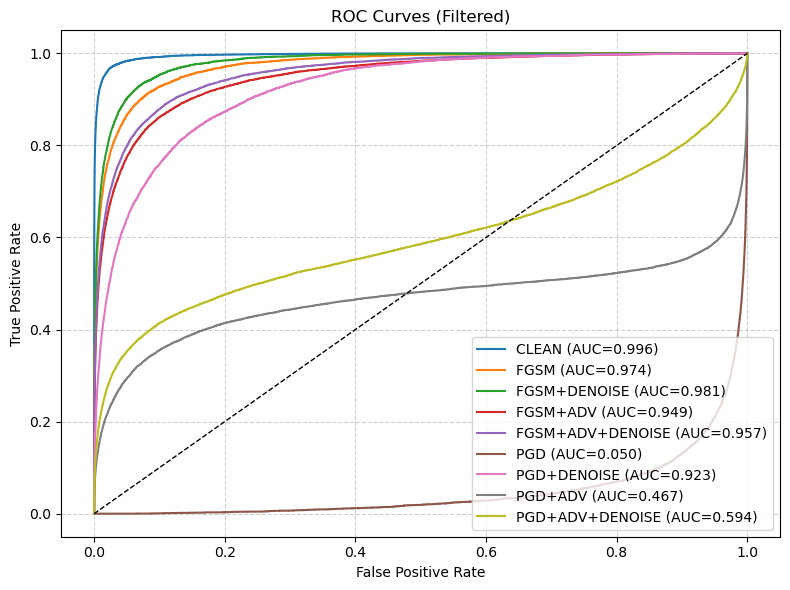

In [ ]:
summary = pd.read_csv("lfw_facenet_summary.csv")

if "setting" not in summary.columns:
    summary = summary.rename(columns={summary.columns[0]: "setting"})

drop_conditions = ["CLEAN+DENOISE", "CLEAN+ADV", "CLEAN+ADV+DENOISE"]
summary = summary[~summary["setting"].isin(drop_conditions)]

print("=== Filtered Summary Metrics ===")
print(summary)

with open("lfw_facenet_roc_curves.pkl", "rb") as f:
    roc_curves = pickle.load(f)

roc_curves = {k: v for k, v in roc_curves.items() if k not in drop_conditions}

plt.figure(figsize=(8, 6))
for setting, data in roc_curves.items():
    fpr = data["fpr"]
    tpr = data["tpr"]
    auc = float(data["auc"])
    plt.plot(fpr, tpr, label=f"{setting} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Filtered)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
